In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")


In [2]:
import session_info
session_info.show()

#### This project can be found in https://github.com/cliff003/DTSA5509  
#### Details of this challenge: https://zindi.africa/competitions/digital-green-crop-yield-estimate-challenge/

In [3]:
train = pd.read_csv( osp.join(osp.curdir,'Train.csv'))
test = pd.read_csv(osp.join(osp.curdir,'Test.csv'))
train_orig = train.copy()

Adding Acre_cat feature by modifying Acre as object column

In [4]:
train['Acre_cat'] = np.round(train['Acre'], 6).astype(str)
test['Acre_cat'] = np.round(test['Acre'], 6).astype(str)

Finding outliers using DBSCAN and fit it into the datset

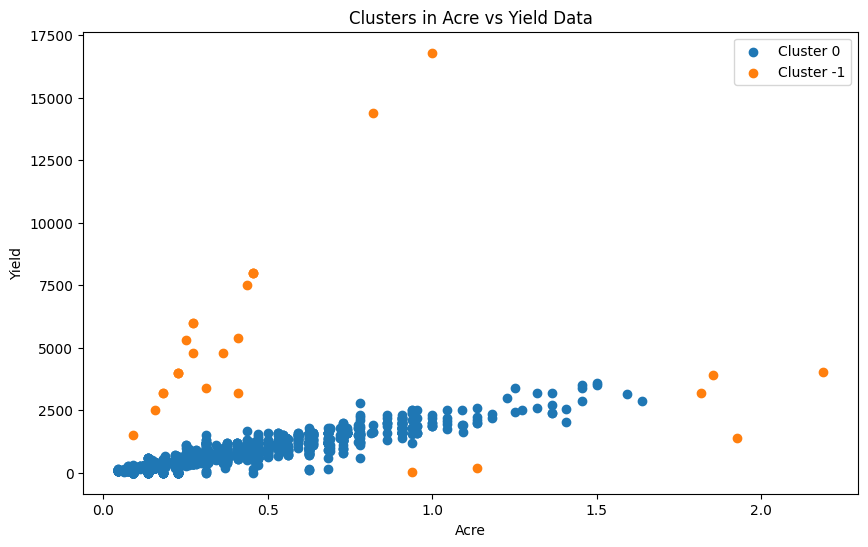

In [5]:
acre_yield_data = train[['Acre', 'Yield']]

scaler = StandardScaler()
acre_yield_scaled = scaler.fit_transform(acre_yield_data)

# Apply DBSCAN clustering algorithm
dbscan = DBSCAN(eps=0.9, min_samples=5)
clusters = dbscan.fit_predict(acre_yield_scaled)
train['Cluster'] = clusters

plt.figure(figsize=(10, 6))

# Plot each cluster
for cluster in set(clusters):
    cluster_data = train[train['Cluster'] == cluster]
    plt.scatter(cluster_data['Acre'], cluster_data['Yield'], label=f'Cluster {cluster}')

plt.title('Clusters in Acre vs Yield Data')
plt.xlabel('Acre')
plt.ylabel('Yield')
plt.legend()
plt.show()

outliers = train[train['Cluster'] == -1].copy()
outliers = outliers.drop('Cluster', axis=1)

In [6]:
# Selecting rows where 'Cluster' is -1 and 'Acre' is less than or equal to 1
mask = (train['Cluster'] == -1) & (train['Acre'] <= 1)

# Dividing 'Yield' by 10 for rows that meet the mask criteria and end with 0
train.loc[mask & (train['Yield'] % 10 == 0), 'Yield'] /= 10

outliers_fit = train[train['Cluster'] == -1].copy()
outliers_fit = outliers_fit.drop('Cluster', axis=1)



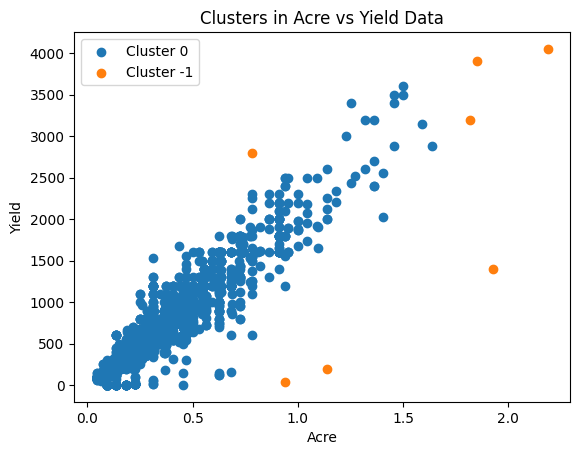

In [7]:
train = train.drop("Cluster", axis=1)

acre_yield_data = train[['Acre', 'Yield']]

scaler = StandardScaler()
acre_yield_scaled = scaler.fit_transform(acre_yield_data)

# Apply DBSCAN clustering algorithm
dbscan = DBSCAN(eps=0.9, min_samples=5)
clusters = dbscan.fit_predict(acre_yield_scaled)
train['Cluster'] = clusters

# Plot each cluster
for cluster in set(clusters):
    cluster_data = train[train['Cluster'] == cluster]
    plt.scatter(cluster_data['Acre'], cluster_data['Yield'], label=f'Cluster {cluster}')

plt.title('Clusters in Acre vs Yield Data')
plt.xlabel('Acre')
plt.ylabel('Yield')
plt.legend()
plt.show()

outliers = train[train['Cluster'] == -1].copy()
outliers = outliers.drop('Cluster', axis=1)

In [8]:
# Selecting rows where 'Cluster' is -1 and 'Acre' is less than or equal to 1
mask = (train['Cluster'] == -1) & (train['Yield'] <= 2000)

# Dividing 'Yield' by 10 for rows that meet the mask criteria and end with 0
train.loc[mask, 'Yield'] *= 10

outliers_fit = train[train['Cluster'] == -1].copy()
outliers_fit = outliers_fit.drop('Cluster', axis=1)

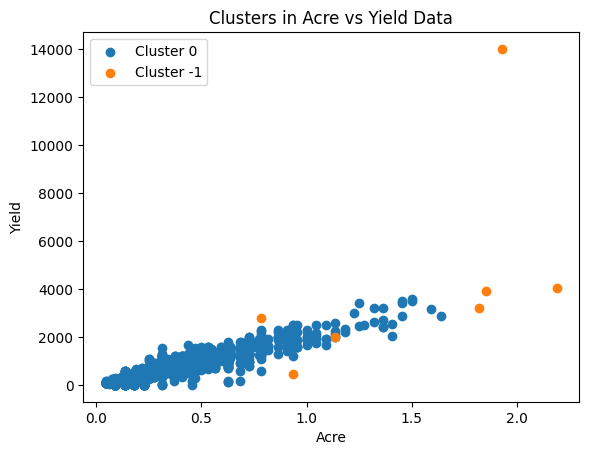

In [9]:
# Combine conditions for dropping rows
condition_to_drop = (train['Yield'] > 10000) | ((train['Cluster'] == -1) & (train['Yield'] <= 500))

# Find the indices of rows that meet either condition
indices_to_drop = train[condition_to_drop].index

# Plot each cluster
for cluster in set(clusters):
    cluster_data = train[train['Cluster'] == cluster]
    plt.scatter(cluster_data['Acre'], cluster_data['Yield'], label=f'Cluster {cluster}')

plt.title('Clusters in Acre vs Yield Data')
plt.xlabel('Acre')
plt.ylabel('Yield')
plt.legend()
plt.show()

train.drop(indices_to_drop, inplace=True)


Final plot after fitting and droping outliers in the training data

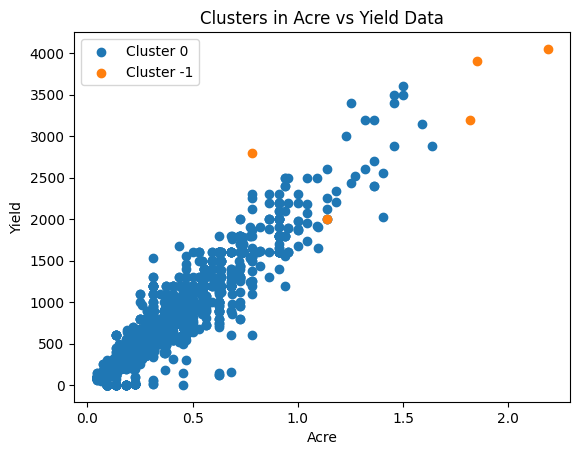

In [10]:
# Plot each cluster
for cluster in set(clusters):
    cluster_data = train[train['Cluster'] == cluster]
    plt.scatter(cluster_data['Acre'], cluster_data['Yield'], label=f'Cluster {cluster}')

plt.title('Clusters in Acre vs Yield Data')
plt.xlabel('Acre')
plt.ylabel('Yield')
plt.legend()
plt.show()

train = train.drop("Cluster", axis=1)

Combine train and test dataset

In [11]:
df = pd.concat([train, test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5158 entries, 0 to 5157
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  5158 non-null   object 
 1   District                            5158 non-null   object 
 2   Block                               5158 non-null   object 
 3   CultLand                            5158 non-null   int64  
 4   CropCultLand                        5158 non-null   int64  
 5   LandPreparationMethod               5158 non-null   object 
 6   CropTillageDate                     5158 non-null   object 
 7   CropTillageDepth                    5158 non-null   int64  
 8   CropEstMethod                       5158 non-null   object 
 9   RcNursEstDate                       5032 non-null   object 
 10  SeedingSowingTransplanting          5158 non-null   object 
 11  SeedlingsPerPit                     4766 no

### Fill Missing values

In [12]:
na_columns = df.columns[df.isna().any()].tolist()
na_columns.pop()

'Yield'

Fill all numeric columns with 0

In [13]:
for column in na_columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column] = df[column].fillna(0)

Fill date columns with '1970-01-01', and fill object column with new placeholder "Unknown".

In [14]:
date_columns = ['CropTillageDate', 'RcNursEstDate', 'SeedingSowingTransplanting', 'Harv_date', 'Threshing_date']
epoch_start = pd.to_datetime('1970-01-01')
for col in date_columns:
    df[col] = pd.to_datetime(df[col]).astype('int64')
    df[col] = df[col].fillna(epoch_start).astype('int64')

na_columns = df.columns[df.isna().any()].tolist()

for column in na_columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna('Unknown')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5158 entries, 0 to 5157
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  5158 non-null   object 
 1   District                            5158 non-null   object 
 2   Block                               5158 non-null   object 
 3   CultLand                            5158 non-null   int64  
 4   CropCultLand                        5158 non-null   int64  
 5   LandPreparationMethod               5158 non-null   object 
 6   CropTillageDate                     5158 non-null   int64  
 7   CropTillageDepth                    5158 non-null   int64  
 8   CropEstMethod                       5158 non-null   object 
 9   RcNursEstDate                       5158 non-null   int64  
 10  SeedingSowingTransplanting          5158 non-null   int64  
 11  SeedlingsPerPit                     5158 no

Apply OneHotEncoder for all categorical columns

In [15]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'ID' in categorical_cols:
    categorical_cols.remove('ID')

encoder = OneHotEncoder()

df_encoded = pd.DataFrame(encoder.fit_transform(df[categorical_cols]).toarray())

df_encoded.columns = encoder.get_feature_names_out(categorical_cols)

df.reset_index(drop=True, inplace=True)
df_encoded.reset_index(drop=True, inplace=True)

df_final = pd.concat([df, df_encoded], axis=1).drop(categorical_cols, axis=1)

df_final.info

<bound method DataFrame.info of                    ID  CultLand  CropCultLand      CropTillageDate  \
0     ID_GTFAC7PEVWQ9        45            40  1658275200000000000   
1     ID_TK40ARLSPOKS        26            26  1658102400000000000   
2     ID_1FJY2CRIMLZZ        10            10  1656547200000000000   
3     ID_I3IPXS4DB7NE        15            15  1655337600000000000   
4     ID_4T8YQWXWHB4A        60            60  1658188800000000000   
...               ...       ...           ...                  ...   
5153  ID_6MMECMX3B728        20            16  1658534400000000000   
5154  ID_GZ9YGWCLLMKN        25            14  1657152000000000000   
5155  ID_01YVA2LJVYBR        10             3  1657065600000000000   
5156  ID_YQRL2IOUU4SZ        10            10  1658448000000000000   
5157  ID_VAX2N8ELPEZE        15            15  1657238400000000000   

      CropTillageDepth        RcNursEstDate  SeedingSowingTransplanting  \
0                    5  1656288000000000000         

Making final train data and test data, apply a log transformation to Yield column to prevent negative values in final prediction

In [16]:
id, label_col = 'ID', 'Yield'
train_data = df_final[df_final[label_col].notna()].copy()
test_data = df_final[df_final[label_col].isna()].copy().drop(label_col, axis=1)

# Apply a log transformation to the Yield column for training
train_data.loc[:, label_col] = np.log1p(train_data[label_col])

### Modeling
Using three models to fit the data, ensemble them using simple averaging.

In [17]:

X = train_data.drop([label_col, id], axis=1)
y = train_data[label_col]
best_rmse = float('inf')
seed = 42

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=seed)

# Initialize the models
extra_trees = ExtraTreesRegressor(n_estimators=100, random_state=seed)
catboost = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=10, silent=True)
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)

# Train the models
et = extra_trees.fit(X_train, y_train)
cb = catboost.fit(X_train, y_train)
lgbm = lgbm.fit(X_train, y_train)

# Make predictions on the validation set
predictions_et = extra_trees.predict(X_val)
predictions_cb = catboost.predict(X_val)
predictions_lgbm = lgbm.predict(X_val)

# Ensemble: simple averaging of predictions
ensemble_predictions = (predictions_et + predictions_cb + predictions_lgbm) / 3

# Evaluate the ensemble model
rmse = mean_squared_error(np.expm1(y_val), np.expm1(ensemble_predictions), squared=False)
print(f"Mean Squared Error of Ensemble: {rmse}")




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 3287, number of used features: 180
[LightGBM] [Info] Start training from score 6.011552
Mean Squared Error of Ensemble: 130.65465576403184


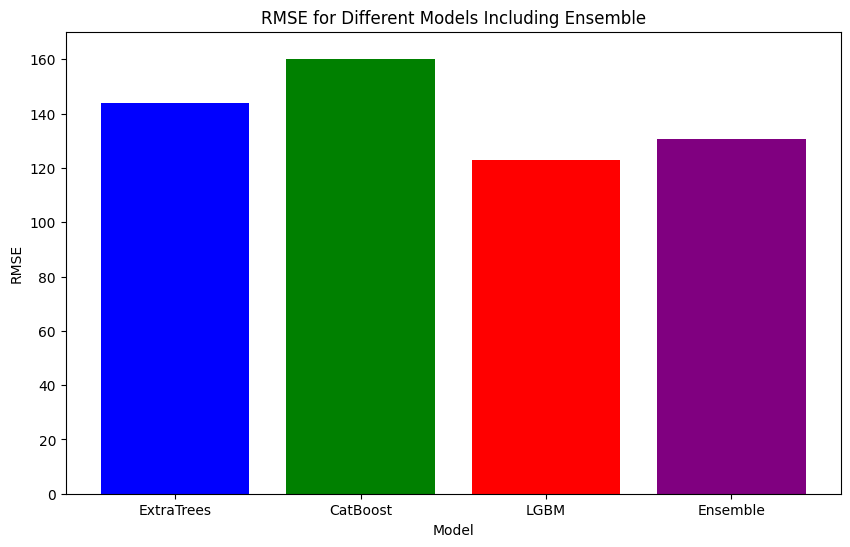

In [18]:
rmse_et = mean_squared_error(np.expm1(y_val), np.expm1(predictions_et), squared=False)
rmse_cb = mean_squared_error(np.expm1(y_val), np.expm1(predictions_cb), squared=False)
rmse_lgbm = mean_squared_error(np.expm1(y_val), np.expm1(predictions_lgbm), squared=False)
rmse_ensemble = rmse

models = ['ExtraTrees', 'CatBoost', 'LGBM', 'Ensemble']
rmse_values = [rmse_et, rmse_cb, rmse_lgbm, rmse_ensemble]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE for Different Models Including Ensemble')
plt.ylim(0, max(rmse_values) + 10)
plt.show()

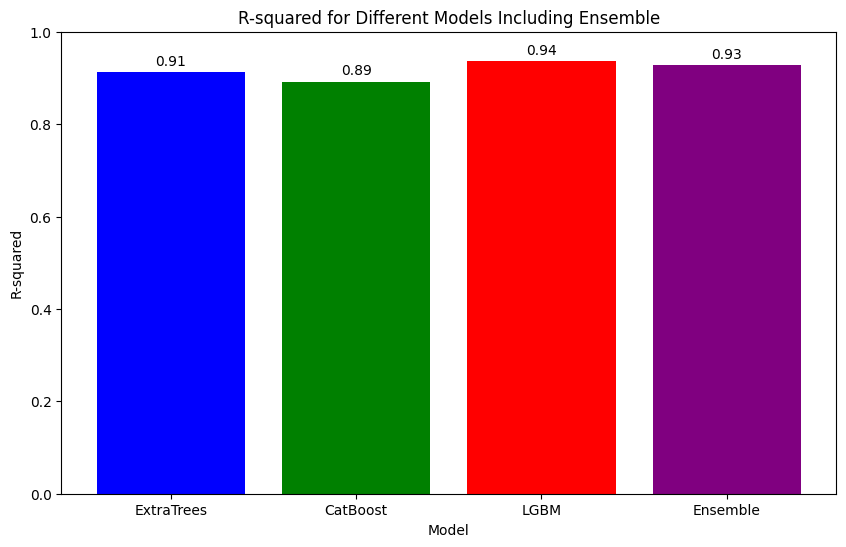

In [19]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2_et = r2_score(np.expm1(y_val), np.expm1(predictions_et))
r2_cb = r2_score(np.expm1(y_val), np.expm1(predictions_cb))
r2_lgbm = r2_score(np.expm1(y_val), np.expm1(predictions_lgbm))
r2_ensemble = r2_score(np.expm1(y_val), np.expm1(ensemble_predictions))

models = ['ExtraTrees', 'CatBoost', 'LGBM', 'Ensemble']
r2_values = [r2_et, r2_cb, r2_lgbm, r2_ensemble]


# Plotting
fig, ax = plt.figure(figsize=(10, 6)), plt.gca()
bars = ax.bar(models, r2_values, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('R-squared for Different Models Including Ensemble')
plt.ylim(0, 1)
plt.show()

In [20]:
X_test = test_data.drop(id, axis=1)
predictions_et = et.predict(X_test)
predictions_cb = cb.predict(X_test)
predictions_lgbm = lgbm.predict(X_test)
ensemble_predictions = (predictions_et + predictions_cb + predictions_lgbm) / 3

# Reverse the log-transformation
final_predictions = np.rint(np.expm1(ensemble_predictions))

final_predictions_df = pd.DataFrame(final_predictions, columns=["Yield"])
final_predictions_df = final_predictions_df.reset_index(drop=True)
submission = pd.DataFrame({id: test[id], label_col: final_predictions_df[label_col]})

### Public leaderboard Tunning
Fun part that makes this model performs well in public leaderborad.  
I was able to find two outliers in the public leaderboard that was hard to get using this method.  
First one was the common outlier 'ID_PMSOXFT4FYDW', this model will predict it as 787, which is aboiut 1/10 of the real value.  
The second one is 'ID_BI4VNVU7JAXF', which is also strange, my predicted value was 1/2 of the true value.  


In [21]:
# Public leaderboard tunning
print(submission.loc[submission[id] == 'ID_PMSOXFT4FYDW', label_col])
submission.loc[submission[id] == 'ID_PMSOXFT4FYDW', 'Yield'] = 8000
print(submission.loc[submission[id] == 'ID_BI4VNVU7JAXF', label_col])
submission.loc[submission[id] == 'ID_BI4VNVU7JAXF', 'Yield'] = 3200


373    787.0
Name: Yield, dtype: float64
1118    1520.0
Name: Yield, dtype: float64


In [22]:
submission.to_csv('final.csv', index=False)